### Simple notebook for loading Amsterdam's EBM Models 

Author: Gabriel Geiger

Unpickling Amsterdam's model files requires specific versions of a number of packages, which have a complicated set of dependencies. The specific version of XGBboost requires <=Python 3.8 and unfortunately we were not able to get the model running on Apple Silicon. We suggest creating a Python 3.8 virtual enviorment and installing the requirements in the requirements.txt file to get started


In [1]:
!pip install -q -r requirements.txt

### Load required packages

In [2]:
import pickle
import joblib as jl
import xgboost
import sys
import os 
import warnings
import numpy as np
import pandas as pd
import itertools
from interpret import show

c:\Users\jetve\anaconda3\envs\fairness38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load models

In [3]:
#The models require the wpi_uiterkeringsfraude package, so we add the parent directory to the system path. 
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Load the original model the city trained 
original_model = jl.load(open('input/20220523_model_used_in_prepilot.pkl', 'rb'))
original_model = original_model['model']

# Load the reweigheted model, which attempted to remove bias against applicants with a non-Western nationality 
reweighted_model = jl.load(open('input/20220531_model_after_reweighing.pkl', 'rb'))
reweighted_model = reweighted_model['model']

### Create explorable dashboard for the original model

In [5]:
pip install dash==2.7.0 dash-core-components==2.0.0 dash-html-components==2.0.0 dash-table==5.0.0


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   -------------- ------------------------- 3.7/9.9 MB 18.1 MB/s eta 0:00:01
   ------------------------------- -------- 7.9/9.9 MB 18.7 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: dash
    Found existing installation: dash 3.2.0
    Uninstalling dash-3.2.0:
      Successfully uninstalled dash-3.2.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Grab the classifier 
grid_search = original_model.named_steps['clf']
ebm_model = grid_search.best_estimator_

# Show explanation
explanation = ebm_model.explain_global()
show(explanation, title='Original Model')

c:\Users\jetve\anaconda3\envs\fairness38\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
c:\Users\jetve\anaconda3\envs\fairness38\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\Users\jetve\anaconda3\envs\fairness38\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/2449645836128/ -->

### Create explorable dashboard for the reweighed model

In [7]:
# Grab the classifier 
grid_search = reweighted_model.named_steps['clf']
ebm_model = grid_search.best_estimator_

# Show explanation
explanation = ebm_model.explain_global()
show(explanation, title='Original Model')

<!-- http://127.0.0.1:7001/2450236536816/ -->

### Generate dummy data 

If we want to take a look at scores, we need to first create some dummy data. We create a dictionary with each feature and assign it a range that we want to vary. We then create a dataset with all combinations. 

In [8]:
# Define the features and the values that we want to vary 
features_values = {
    'deelnames_started_percentage_last_year': (0, 4),
    'at_least_one_address_in_amsterdam': 1,
    'active_address_count': (0, 2),
    'days_since_last_relocation': (2000, 90),  
    'days_since_last_dienst_end': (0, 300),
    'has_medebewoner': (0, 1),  
    'avg_percentage_maatregel': (0, 10),
    'total_vermogen': (3000, -10000),  
    'afspraken_no_show_count_last_year': (0, 1),  
    'has_partner': (1, 0),  
    'applied_for_same_product_last_year': (0, 1),
    'received_same_product_last_year': (0, 1),
    'afspraken_no_contact_count_last_year': (0, 1),
    'sum_inkomen_bruto': (1000, 0),
    'sum_inkomen_bruto_was_mean_imputed': (0, 1)
}

# If there are any features we want to keep fixed, we can do that here.
fixed = {k: v for k, v in features_values.items() if not isinstance(v, tuple)}

# Otherwise vary all features that have a tuple range 
variable = {k: v for k, v in features_values.items() if isinstance(v, tuple)}

# Zip and then run through all combinations 
keys, value_lists = zip(*variable.items())
combinations = list(itertools.product(*value_lists))

profiles = []
for combo in combinations:
    profile = fixed.copy()
    profile.update(dict(zip(keys, combo)))
    profiles.append(profile)

df = pd.DataFrame(profiles)

df

,at_least_one_address_in_amsterdam,deelnames_started_percentage_last_year,active_address_count,days_since_last_relocation,days_since_last_dienst_end,has_medebewoner,avg_percentage_maatregel,total_vermogen,afspraken_no_show_count_last_year,has_partner,applied_for_same_product_last_year,received_same_product_last_year,afspraken_no_contact_count_last_year,sum_inkomen_bruto,sum_inkomen_bruto_was_mean_imputed
0,1,0,0,2000,0,0,0,3000,0,1,0,0,0,1000,0
1,1,0,0,2000,0,0,0,3000,0,1,0,0,0,1000,1
2,1,0,0,2000,0,0,0,3000,0,1,0,0,0,0,0
3,1,0,0,2000,0,0,0,3000,0,1,0,0,0,0,1
4,1,0,0,2000,0,0,0,3000,0,1,0,0,1,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,1,4,2,90,300,1,10,-10000,1,0,1,1,0,0,1
16380,1,4,2,90,300,1,10,-10000,1,0,1,1,1,1000,0
16381,1,4,2,90,300,1,10,-10000,1,0,1,1,1,1000,1
16382,1,4,2,90,300,1,10,-10000,1,0,1,1,1,0,0


### Now we score our data with both the orignal and reweighted model

In [9]:
# Score with original model 
df["original_model_score"] = original_model.predict_proba(df)[:, 1]

# Score with reweighted model
df["reweighted_model_score"] = reweighted_model.predict_proba(df)[:, 1]

df

,at_least_one_address_in_amsterdam,deelnames_started_percentage_last_year,active_address_count,days_since_last_relocation,days_since_last_dienst_end,has_medebewoner,avg_percentage_maatregel,total_vermogen,afspraken_no_show_count_last_year,has_partner,applied_for_same_product_last_year,received_same_product_last_year,afspraken_no_contact_count_last_year,sum_inkomen_bruto,sum_inkomen_bruto_was_mean_imputed,original_model_score,reweighted_model_score
0,1,0,0,2000,0,0,0,3000,0,1,0,0,0,1000,0,0.536809,0.520268
1,1,0,0,2000,0,0,0,3000,0,1,0,0,0,1000,1,0.536809,0.520268
2,1,0,0,2000,0,0,0,3000,0,1,0,0,0,0,0,0.589183,0.686612
3,1,0,0,2000,0,0,0,3000,0,1,0,0,0,0,1,0.589183,0.686612
4,1,0,0,2000,0,0,0,3000,0,1,0,0,1,1000,0,0.438069,0.420801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,1,4,2,90,300,1,10,-10000,1,0,1,1,0,0,1,0.586412,0.568806
16380,1,4,2,90,300,1,10,-10000,1,0,1,1,1,1000,0,0.435256,0.304315
16381,1,4,2,90,300,1,10,-10000,1,0,1,1,1,1000,1,0.435256,0.304315
16382,1,4,2,90,300,1,10,-10000,1,0,1,1,1,0,0,0.488164,0.469134


### Plot differences between scores two models produce

<Axes: >

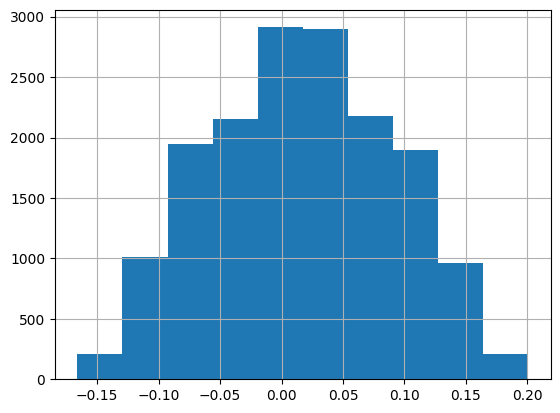

In [10]:
df['score_difference'] = df['original_model_score'] - df['reweighted_model_score']
df['score_difference'].hist()

### Save output as spreadsheet

In [109]:
df.to_csv('output/model_scoring_comparison.csv', index = False)